# SETUP

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models

In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=8,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


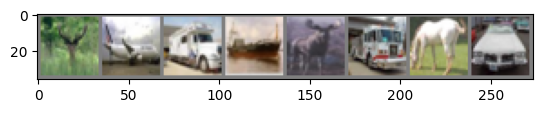

 deer plane truck  ship  deer truck horse   car


In [6]:
# The function to show an image.
def imshow(img):
    img = img / 2 + 0.5     # Unnormalize.
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images.
dataiter = iter(trainloader)
images, labels = next(dataiter)
# Show images.
imshow(torchvision.utils.make_grid(images))
# Print labels.
print(' '.join('%5s' % classes[labels[j]] for j in range(8)))

In [7]:
# If there are GPUs, choose the first one for computing. Otherwise use CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  
# If 'cuda:0' is printed, it means GPU is available.

cpu


# NETWORK DEFFINITIONS

## V your's works here too Jason

In [8]:
class NetVanilla(nn.Module): # Max pooling, size 5 kernels
    def __init__(self):
        super(NetVanilla, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.lin1 = nn.Linear(32 * 8 * 8, 64)
        self.lin2 = nn.Linear(64, 10)
        
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = nn.functional.relu(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = nn.functional.relu(x)
        x = self.pool2(x)
        
        x = x.view(-1, 32 * 8 * 8)
        
        x = self.lin1(x)
        x = nn.functional.relu(x)
        x = self.lin2(x)
        
        return x

netVanilla = NetVanilla()     # Create the network instance.
netVanilla.to(device)  # Move the network parameters to the specified device.
print("")

In [9]:
class Net4(nn.Module): # AKA NetVanillaV2
    def __init__(self):
        super(Net4, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # self.skip = nn.Conv2d(3, 16, kernel_size=8, stride=4, padding=2)
        # self.skipBn = nn.BatchNorm2d(8)
        # self.skipPool = nn.AvgPool2d(kernel_size=2, stride=2)
        # output = 16*4*4
        
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128, 256, kernel_size=5, stride=1, padding=2)
        self.bn5 = nn.BatchNorm2d(256)
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.lin1 = nn.Linear(256 * 4 * 4, 256)
        self.lin2 = nn.Linear(256, 64)
        self.lin3 = nn.Linear(64, 10)
        
        self.drop = nn.Dropout(0.5)
        
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = nn.functional.relu(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = nn.functional.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = nn.functional.relu(x)
        x = self.pool3(x)
        
        x = self.conv4(x)
        x = self.bn4(x)
        x = nn.functional.relu(x)
        x = self.conv5(x)
        x = self.bn5(x)
        x = nn.functional.relu(x)
        x = self.pool5(x)
        
        x = x.view(-1, 256 * 4 * 4)
        
        x = self.lin1(x)
        x = nn.functional.relu(x)
        x = self.drop(x)
        x = self.lin2(x)
        x = nn.functional.relu(x)
        x = self.lin3(x)
        
        return x

net4 = Net4()     # Create the network instance.
net4.to(device)  # Move the network parameters to the specified device.
print("")

In [13]:
class Net4Residual(nn.Module): # AKA Net4R
    def __init__(self):
        super(Net4Residual, self).__init__()
        
        self.Block1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.Squish1 = nn.Sequential(
            nn.Linear(16*16*16, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5)
        )
        
        self.Block2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.Squish2 = nn.Sequential(
            nn.Linear(64*8*8, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5)
        )
        
        self.Block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.Squish3 = nn.Sequential(
            nn.Linear(256*4*4, 256),
            nn.ReLU(inplace=True)
        )
        
        self.Classifier = nn.Sequential(
            nn.Linear(256+256, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 10)
        )
        
        
    def forward(self, x):
        x = self.Block1(x)
        x1 = x.view(-1, 16*16*16)
        x1 = self.Squish1(x1)
        
        x = self.Block2(x)
        x2 = x.view(-1, 64*8*8)
        x2 = self.Squish2(x2)
        
        x = self.Block3(x)
        x3 = x.view(-1, 256*4*4)
        x3 = self.Squish3(x3)
        
        x = torch.cat([x2, x3], dim=1)
        x = self.Classifier(x)
        
        return x

net4Residual = Net4Residual()     # Create the network instance.
net4Residual.to(device)  # Move the network parameters to the specified device.
print("")

In [24]:
class NetParallel(nn.Module): # AKA NetE
    def __init__(self):
        super(NetParallel, self).__init__()
        
        self.Block1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.Block2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.PassLayer = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=8, stride=4, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 64, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(64*2*2, 128),
            nn.Dropout(0.7)
        )
        
        # takes x1
        self.ALayer = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(64*8*8, 512),
            nn.Dropout(0.5)
        )
        # takes x2
        self.BLayer = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(128*4*4, 512),
            nn.Dropout(0.5)
        )
#         # takes x2
#         self.CLayer = nn.Sequential(
#             nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
#             nn.BatchNorm2d(64),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(128),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.Flatten(),
#             nn.Linear(128*2*2, 512),
#             nn.Dropout(0.5)
#         )
#         # takes x1
#         self.DLayer = nn.Sequential(
#             nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
#             nn.BatchNorm2d(32),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(64),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.Flatten(),
#             nn.Linear(64*4*4, 512),
#             nn.Dropout(0.5)
#         )
        
        # takes torch.cat((xPass, xA, xB))
        self.Classifier = nn.Sequential(
            nn.Linear(512+512+128, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 10)
        )
        
        
    def forward(self, x):
        x1 = x
        x1 = self.Block1(x1)
        x2 = self.Block2(x1)
        
        xPass = self.PassLayer(x)
        xA = self.ALayer(x1)
        xB = self.BLayer(x2)

        # print(xA.shape, xB.shape, xC.shape, xSkip.shape)
        xF = torch.cat([xA, xB, xPass], dim=1)
        xF = self.Classifier(xF)
        
        return xF

netParallel = NetParallel()     # Create the network instance.
netParallel.to(device)  # Move the network parameters to the specified device.
print("")

# TRAINING

In [ ]:
######### LOAD PREVIOUS TRAINED PARAMETERS #########

netVanilla.load_state_dict(torch.load('./netVanilla_params_clean.pth'))
net4.load_state_dict(torch.load('./net4_params_clean.pth'))
net4Residual.load_state_dict(torch.load('./net4Residual_params_clean.pth'))
netParallel.load_state_dict(torch.load('./netParallel_params_clean.pth'))

running Parallel!
[epoch: 0, i:   999] avg mini-batch loss: 2.014
[epoch: 0, i:  1999] avg mini-batch loss: 1.701
[epoch: 0, i:  2999] avg mini-batch loss: 1.548
[epoch: 0, i:  3999] avg mini-batch loss: 1.467
[epoch: 0, i:  4999] avg mini-batch loss: 1.422
[epoch: 0, i:  5999] avg mini-batch loss: 1.333
[epoch: 0] avg mini-batch loss: 1.333
Finished Training.


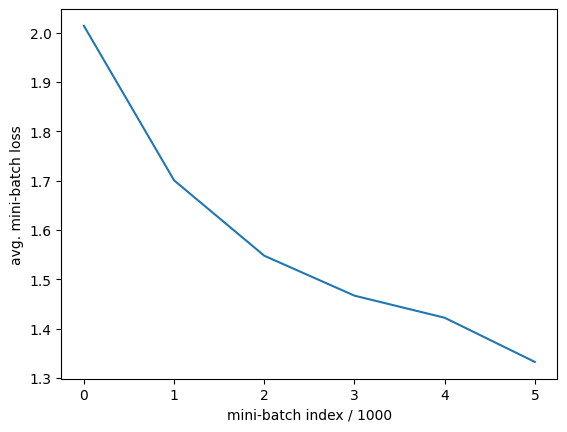

In [25]:
# We use cross-entropy as loss function.
loss_func = nn.CrossEntropyLoss()  
# We use stochastic gradient descent (SGD) as optimizer.
opt = optim.SGD(netParallel.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-5)

avg_losses = []   # Avg. losses.
epochs = 1       # Total epochs.
print_freq = 1000  # Print frequency.

for epoch in range(epochs):  # Loop over the dataset multiple times.
    running_loss = 0.0       # Initialize running loss.
    print("running Parallel!")
    for i, data in enumerate(trainloader, 0):
        # Get the inputs.
        inputs, labels = data
        
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients.
        opt.zero_grad()

        # Forward step.
        outputs = netParallel(inputs)
        # print(inputs.shape, outputs.shape)
        loss = loss_func(outputs, labels)
        
        # Backward step.
        loss.backward()
        
        # Optimization step (update the parameters).
        opt.step()

        # Print statistics.
        running_loss += loss.item()
        if i % print_freq == print_freq - 1: # Print every several mini-batches.
            avg_loss = running_loss / print_freq
            avg_losses.append(avg_loss)
            running_loss = 0.0
            print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f}'.format(
                epoch, i, avg_loss))
    print('[epoch: {}] avg mini-batch loss: {:.3f}'.format(epoch, avg_losses[len(avg_losses)-1]))

print('Finished Training.')

plt.plot(avg_losses)
plt.xlabel('mini-batch index / {}'.format(print_freq))
plt.ylabel('avg. mini-batch loss')
plt.show()

In [26]:
# Save your model's parameters to a file
torch.save(netVanilla.state_dict(), './netVanilla_params_clean.pth')
torch.save(net4.state_dict(), './net4_params_clean.pth')
torch.save(net4Residual.state_dict(), './net4Residual_params_clean.pth')
torch.save(netParallel.state_dict(), './netParallel_params_clean.pth')

# TESTING

In [27]:
# Get train accuracy.
correct = 0
total = 0
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = netVanilla(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the TRAINING images: %d %%' % (
    100 * correct / total))

# Get test accuracy.
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = netVanilla(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

# to beat: 79 % (4) (5 layer conv, 256 width)
# -> 83 % (5 old) (3 parallel, skip, 5 layers deep, 256 width)
# -> 77 (first 10 of 5 new)
# -> 76 (first 10 of E) -> 78 (after 4? fine-tune epochs) -> 76 (after more dropout)

# Get test accuracy for each class.
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = netVanilla(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of the network on the TRAINING images: 56 %
Accuracy of the network on the 10000 test images: 54 %
Accuracy of plane : 68 %
Accuracy of   car : 76 %
Accuracy of  bird : 44 %
Accuracy of   cat : 35 %
Accuracy of  deer : 33 %
Accuracy of   dog : 47 %
Accuracy of  frog : 68 %
Accuracy of horse : 65 %
Accuracy of  ship : 60 %
Accuracy of truck : 46 %


In [31]:
# ENSEMBLE CLASSIFICATION

# Using AVG
# Get test accuracy.
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs1 = F.normalize(netVanilla(images), p=2, dim=1)
        outputs2 = F.normalize(net4(images), p=2, dim=1)
        outputs3 = F.normalize(net4Residual(images), p=2, dim=1)
        outputs4 = F.normalize(netParallel(images), p=2, dim=1)
        # print(outputs1.data)
        # outputs = torch.cat((outputs1, outputs2), dim=1)
        torch.add(torch.add(outputs1, outputs2), torch.add(outputs3, outputs4))
        # print(outputs.data)
        _, predicted = torch.max(outputs, 1)
        predicted = predicted%10
        # print(predicted, predictedn, labels)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

# SHOULD WE NORM OUTPUTS BEFORE THIS ??!
# WE CAN ALSO ADJUST LEARNING RATE AS WE PROCEED THROUGH THE DATA - PERHAPS IN REAL-TIME BY NATURE OF AN ALGORITHM?!

# 1,1 = 73
# 2,1 = 68
# 1,2 = 72
# 2,2 = 73


# using torch.add = 74
# vs 73




# Get test accuracy for each class.
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs1 = F.normalize(netVanilla(images), p=2, dim=1)
        outputs2 = F.normalize(net4(images), p=2, dim=1)
        outputs3 = F.normalize(net4Residual(images), p=2, dim=1)
        outputs4 = F.normalize(netParallel(images), p=2, dim=1)
        outputs = torch.add(torch.add(outputs1, outputs2), torch.add(outputs3, outputs4))
        _, predicted = torch.max(outputs, 1)
        predicted = predicted%10
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of the network on the 10000 test images: 10 %
Accuracy of plane : 67 %
Accuracy of   car : 79 %
Accuracy of  bird : 44 %
Accuracy of   cat : 42 %
Accuracy of  deer : 45 %
Accuracy of   dog : 49 %
Accuracy of  frog : 68 %
Accuracy of horse : 66 %
Accuracy of  ship : 70 %
Accuracy of truck : 65 %


In [32]:
# ENSEMBLE CLASSIFICATION

# Using MAX
# Get test accuracy.
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs1 = F.normalize(netVanilla(images), p=2, dim=1)
        outputs2 = F.normalize(net4(images), p=2, dim=1)
        outputs3 = F.normalize(net4Residual(images), p=2, dim=1)
        outputs4 = F.normalize(netParallel(images), p=2, dim=1)
        # print(outputs1.data)
        # outputs = torch.cat((outputs1, outputs2), dim=1)
        outputs = torch.cat((outputs1, outputs2, outputs3, outputs4), dim=1)
        # print(outputs.data)
        _, predicted = torch.max(outputs, 1)
        predicted = predicted%10
        # print(predicted, predictedn, labels)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

# SHOULD WE NORM OUTPUTS BEFORE THIS ??!
# WE CAN ALSO ADJUST LEARNING RATE AS WE PROCEED THROUGH THE DATA - PERHAPS IN REAL-TIME BY NATURE OF AN ALGORITHM?!

# 1,1 = 73
# 2,1 = 68
# 1,2 = 72
# 2,2 = 73


# using torch.add = 74
# vs 73




# Get test accuracy for each class.
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs1 = F.normalize(netVanilla(images), p=2, dim=1)
        outputs2 = F.normalize(net4(images), p=2, dim=1)
        outputs3 = F.normalize(net4Residual(images), p=2, dim=1)
        outputs4 = F.normalize(netParallel(images), p=2, dim=1)
        torch.cat((outputs1, outputs2, outputs3, outputs4), dim=1)
        _, predicted = torch.max(outputs, 1)
        predicted = predicted%10
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of the network on the 10000 test images: 10 %
Accuracy of plane :  0 %
Accuracy of   car : 26 %
Accuracy of  bird :  0 %
Accuracy of   cat : 24 %
Accuracy of  deer :  0 %
Accuracy of   dog : 25 %
Accuracy of  frog :  0 %
Accuracy of horse : 25 %
Accuracy of  ship :  0 %
Accuracy of truck :  0 %
